# Coursework 1
## Information Visualization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import warnings
from matplotlib.gridspec import GridSpec
from squarify import plot

warnings.filterwarnings(action='ignore', category=UserWarning)

matplotlib.rc('font', size=11)

df = pd.read_csv("IV cw 1 2022 dataset.csv", parse_dates=["Usage date"])
df = df.set_index("Usage date")

## Task A

In [2]:
# Line chart: Monthly spending
monthly_total = df.groupby(pd.Grouper(freq='M')).sum("Spend to Date")
monthly_individual = df.groupby("Project ID").apply(lambda x: x.groupby(pd.Grouper(freq='M')).sum("Spend to Date")).unstack(0).droplevel(0, axis=1)
monthly_individual = monthly_individual[monthly_individual.sum().sort_values(ascending=False).index[:3]]

# Stacked bar chart: Cost of resources per project
prices_per_resource = df.groupby(["Project ID", "ResourceType.2.1", "Type"]).sum("Spend to Date")
prices_per_resource.index = pd.MultiIndex.from_tuples(map(lambda x: (x[0], '/'.join(x[1:])), prices_per_resource.index), names=['Project ID', 'Resource'])
prices_per_resource = prices_per_resource.unstack(0).droplevel(0, axis=1).fillna(0)
prices_per_resource = prices_per_resource[prices_per_resource.sum().sort_values(ascending=False).index[:len(prices_per_resource.columns)//2]]

# Boxplot: Number of resources in each resource group
resource_group_sizes = df.groupby(["ResourceGroupName"]).count().ResourceId.rename("Resource count per group").sort_values(ascending=False)

# Tree map: Cost per resource type
resource_cost = df.groupby(["Type"]).sum("Spend to Date").squeeze()
resource_cost = resource_cost[resource_cost > 0].sort_values(ascending=False)

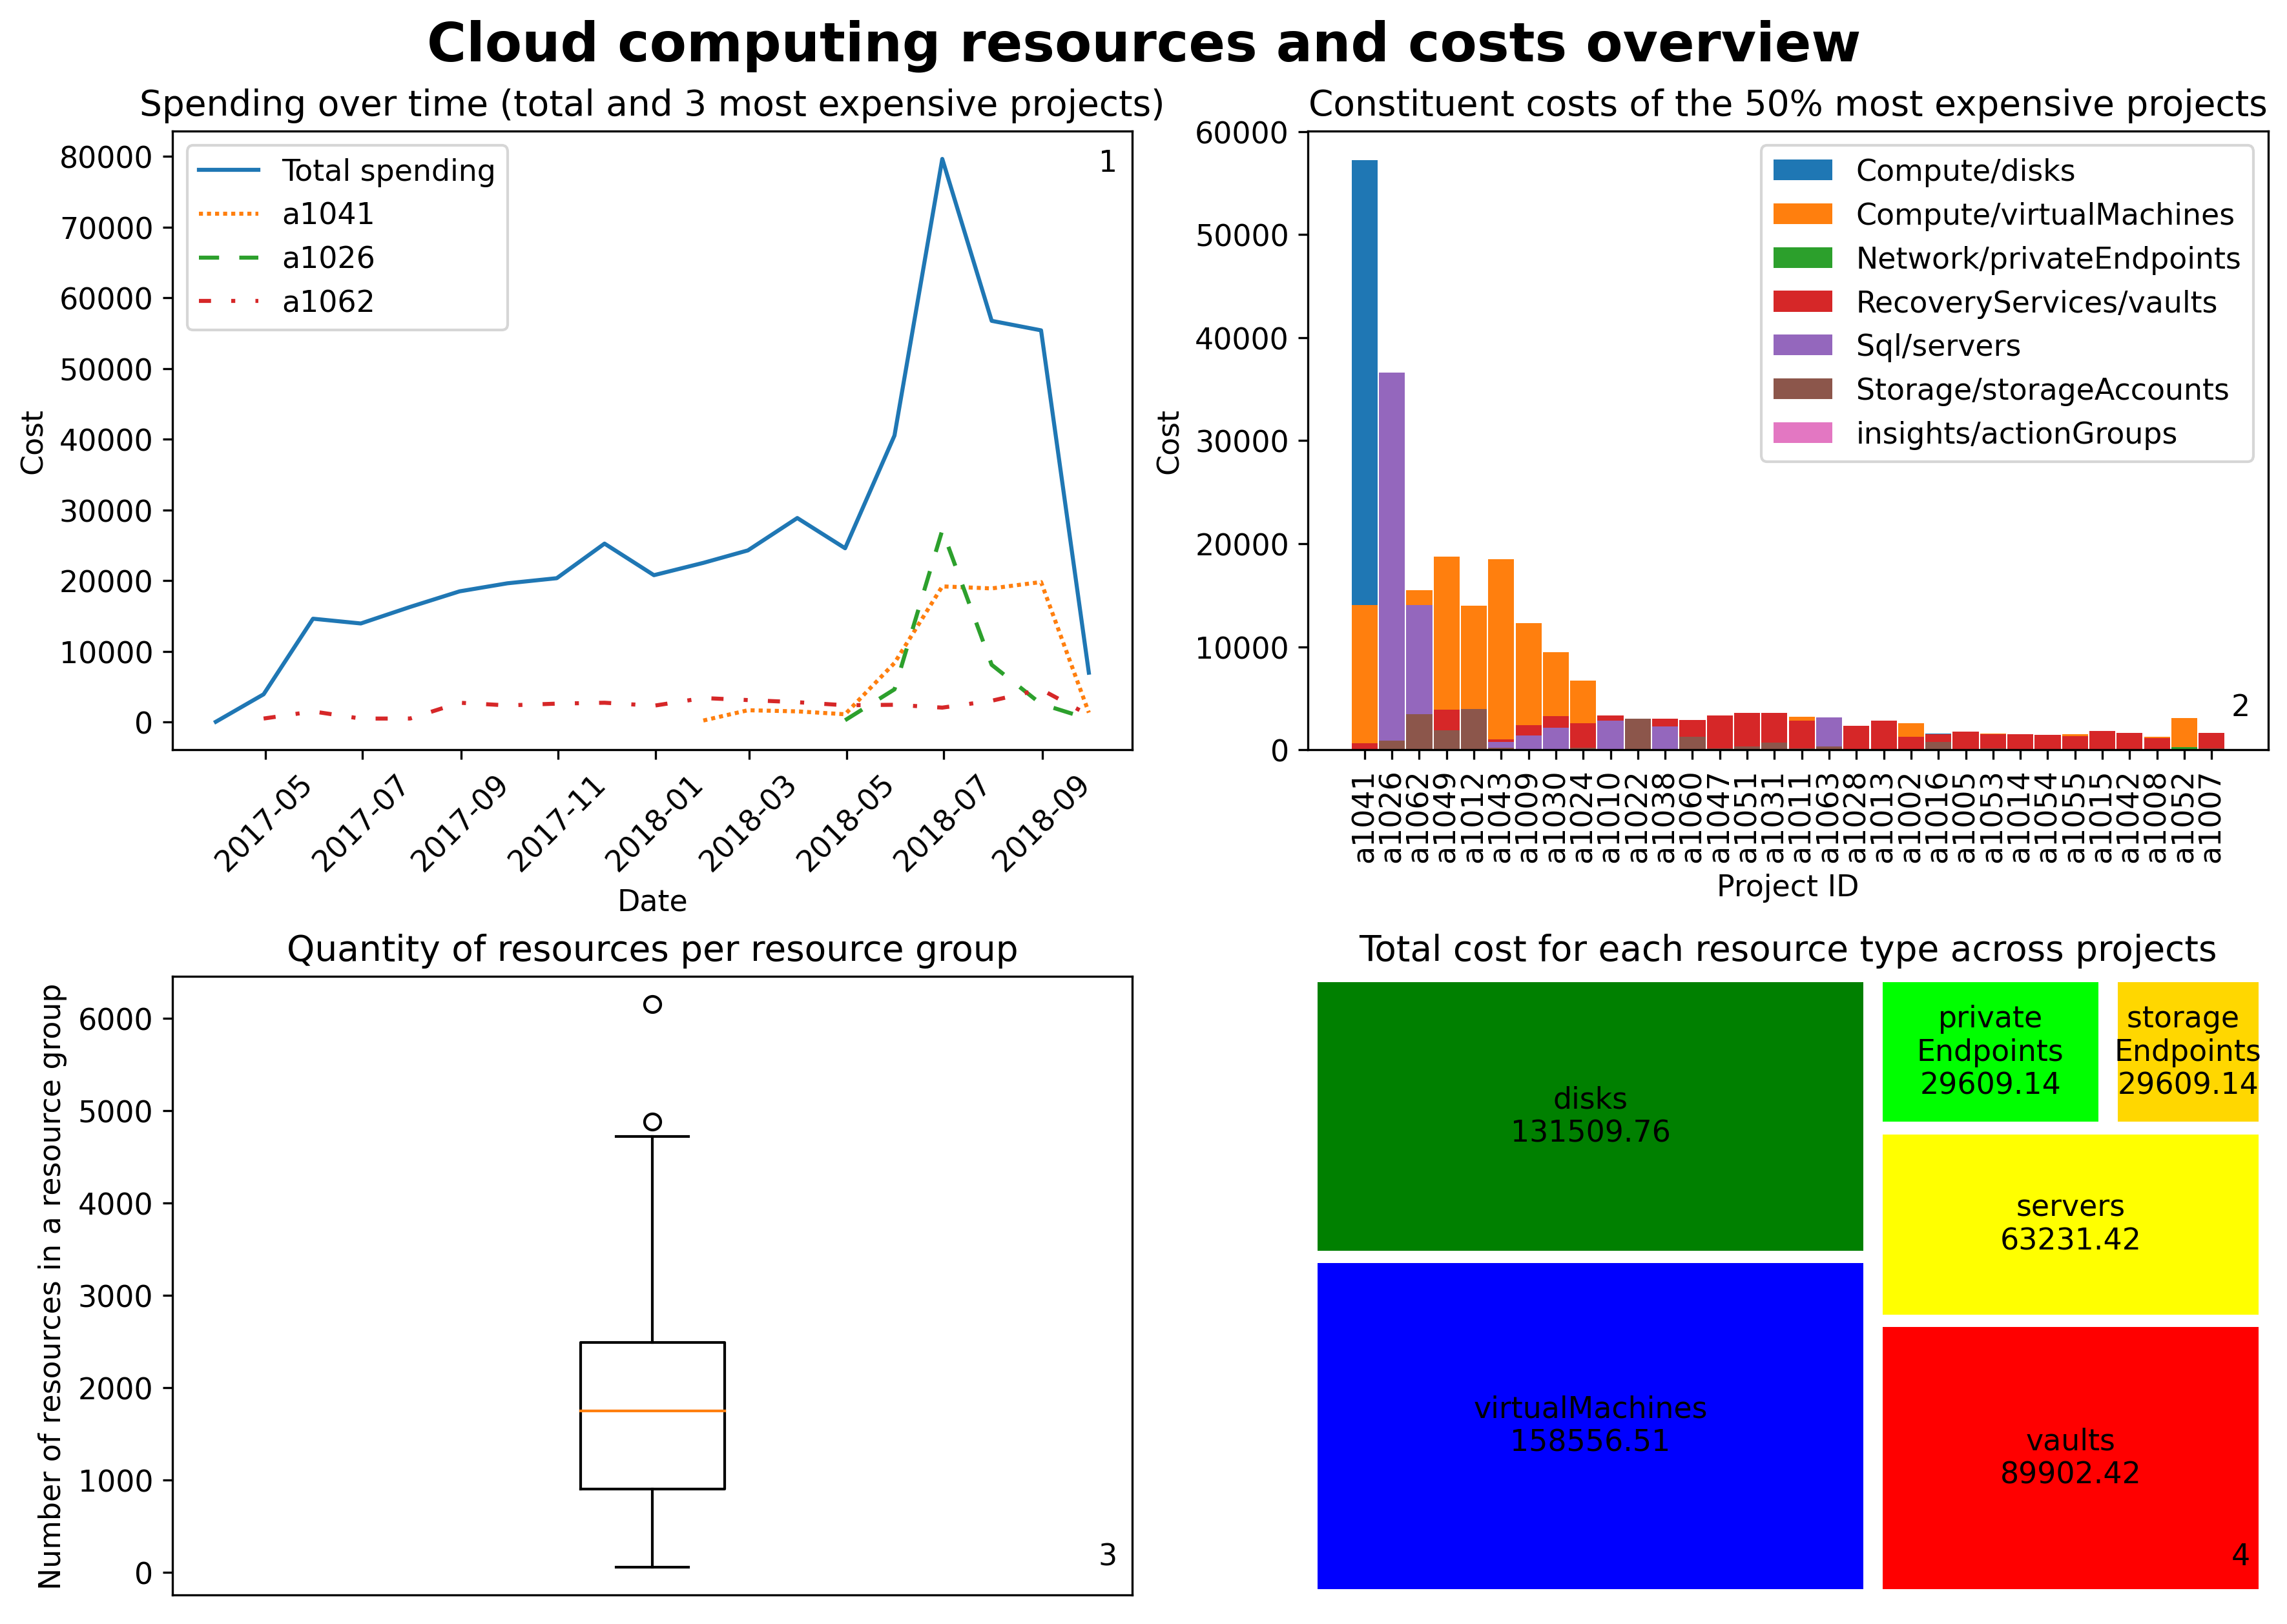

In [3]:
fig, axs = plt.subplots(2, 2, figsize=(11.69, 8.27), dpi=300, constrained_layout=True)

ax = axs[0, 0]
styles = [(0, (1, 1)), (0, (5, 5)), (0, (3, 5, 1, 5))]
ax.plot(monthly_total, label="Total spending")
for ((label, line), style) in zip(monthly_individual.items(), styles):
    ax.plot(line, linestyle=style, label=label)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_xlabel("Date")
ax.set_ylabel("Cost")
ax.set_title("Spending over time (total and 3 most expensive projects)")
fig.text(0.48, 0.9, '1')
ax.legend()

ax = axs[0, 1]
for label, data in prices_per_resource.iterrows():
    ax.bar(prices_per_resource.columns, data, 0.95, label=label)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel("Project ID")
ax.set_ylabel("Cost")
ax.set_title("Constituent costs of the 50% most expensive projects")
fig.text(0.98, 0.56, '2')
ax.legend()

ax = axs[1, 0]
ax.boxplot(resource_group_sizes)
ax.set_xticks([])
ax.set_ylabel("Number of resources in a resource group")
ax.set_title("Quantity of resources per resource group")
fig.text(0.48, 0.03, '3')

labels = [f"{l}\n{c:.2f}" for l, c in zip(resource_cost.index, resource_cost)]
labels[-2] = labels[-2][:7] + '\n' + labels[-2][7:]
labels[-1] = labels[-1][:7] + ' ' + labels[-2][7:]
colors = ['b', 'g', 'r', 'yellow', 'lime', 'gold']
plot(sizes=resource_cost.to_numpy(), label=labels, color=colors, pad=1)
plt.axis("off")
plt.title("Total cost for each resource type across projects")
fig.text(0.98, 0.03, '4')

plt.suptitle("Cloud computing resources and costs overview", weight='bold', fontsize=20)
plt.show()

## Task B

In [4]:
prices_per_resource = df.groupby(["Project ID", "Type"]).sum("Spend to Date")
prices_per_resource = prices_per_resource.unstack(0).droplevel(0, axis=1).fillna(0)
prices_per_resource = prices_per_resource[prices_per_resource.sum().sort_values(ascending=False).index]

In [5]:
def plot_bar(ax, label, data):
    ax.bar(data.index, data, 0.9)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_title(label)
    for n in data.reset_index(drop=True)[(data == 0).reset_index(drop=True)].index:
        ax.text(n, 2020, s="x", ha='center', va='center', fontsize=15, weight='bold')
        
def plot_box(ax1, ax2):
    ax1.set_xlim(-100, 8000)
    ax2.set_xlim(8000, 60000) # outliers

    labels, data = [], []
    for l, d in prices_per_resource.iterrows():
        labels.append(l)
        data.append(d)
    ax1.boxplot(data, labels=labels, vert=False)
    ax2.boxplot(data, labels=labels, vert=False)

    ax1.spines.right.set_visible(False)
    ax2.spines.left.set_visible(False)
    ax2.tick_params(labelleft=False, left=False)

    d = 1  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                  linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax1.plot([1, 1], [0, 1], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 0], [0, 1], transform=ax2.transAxes, **kwargs)

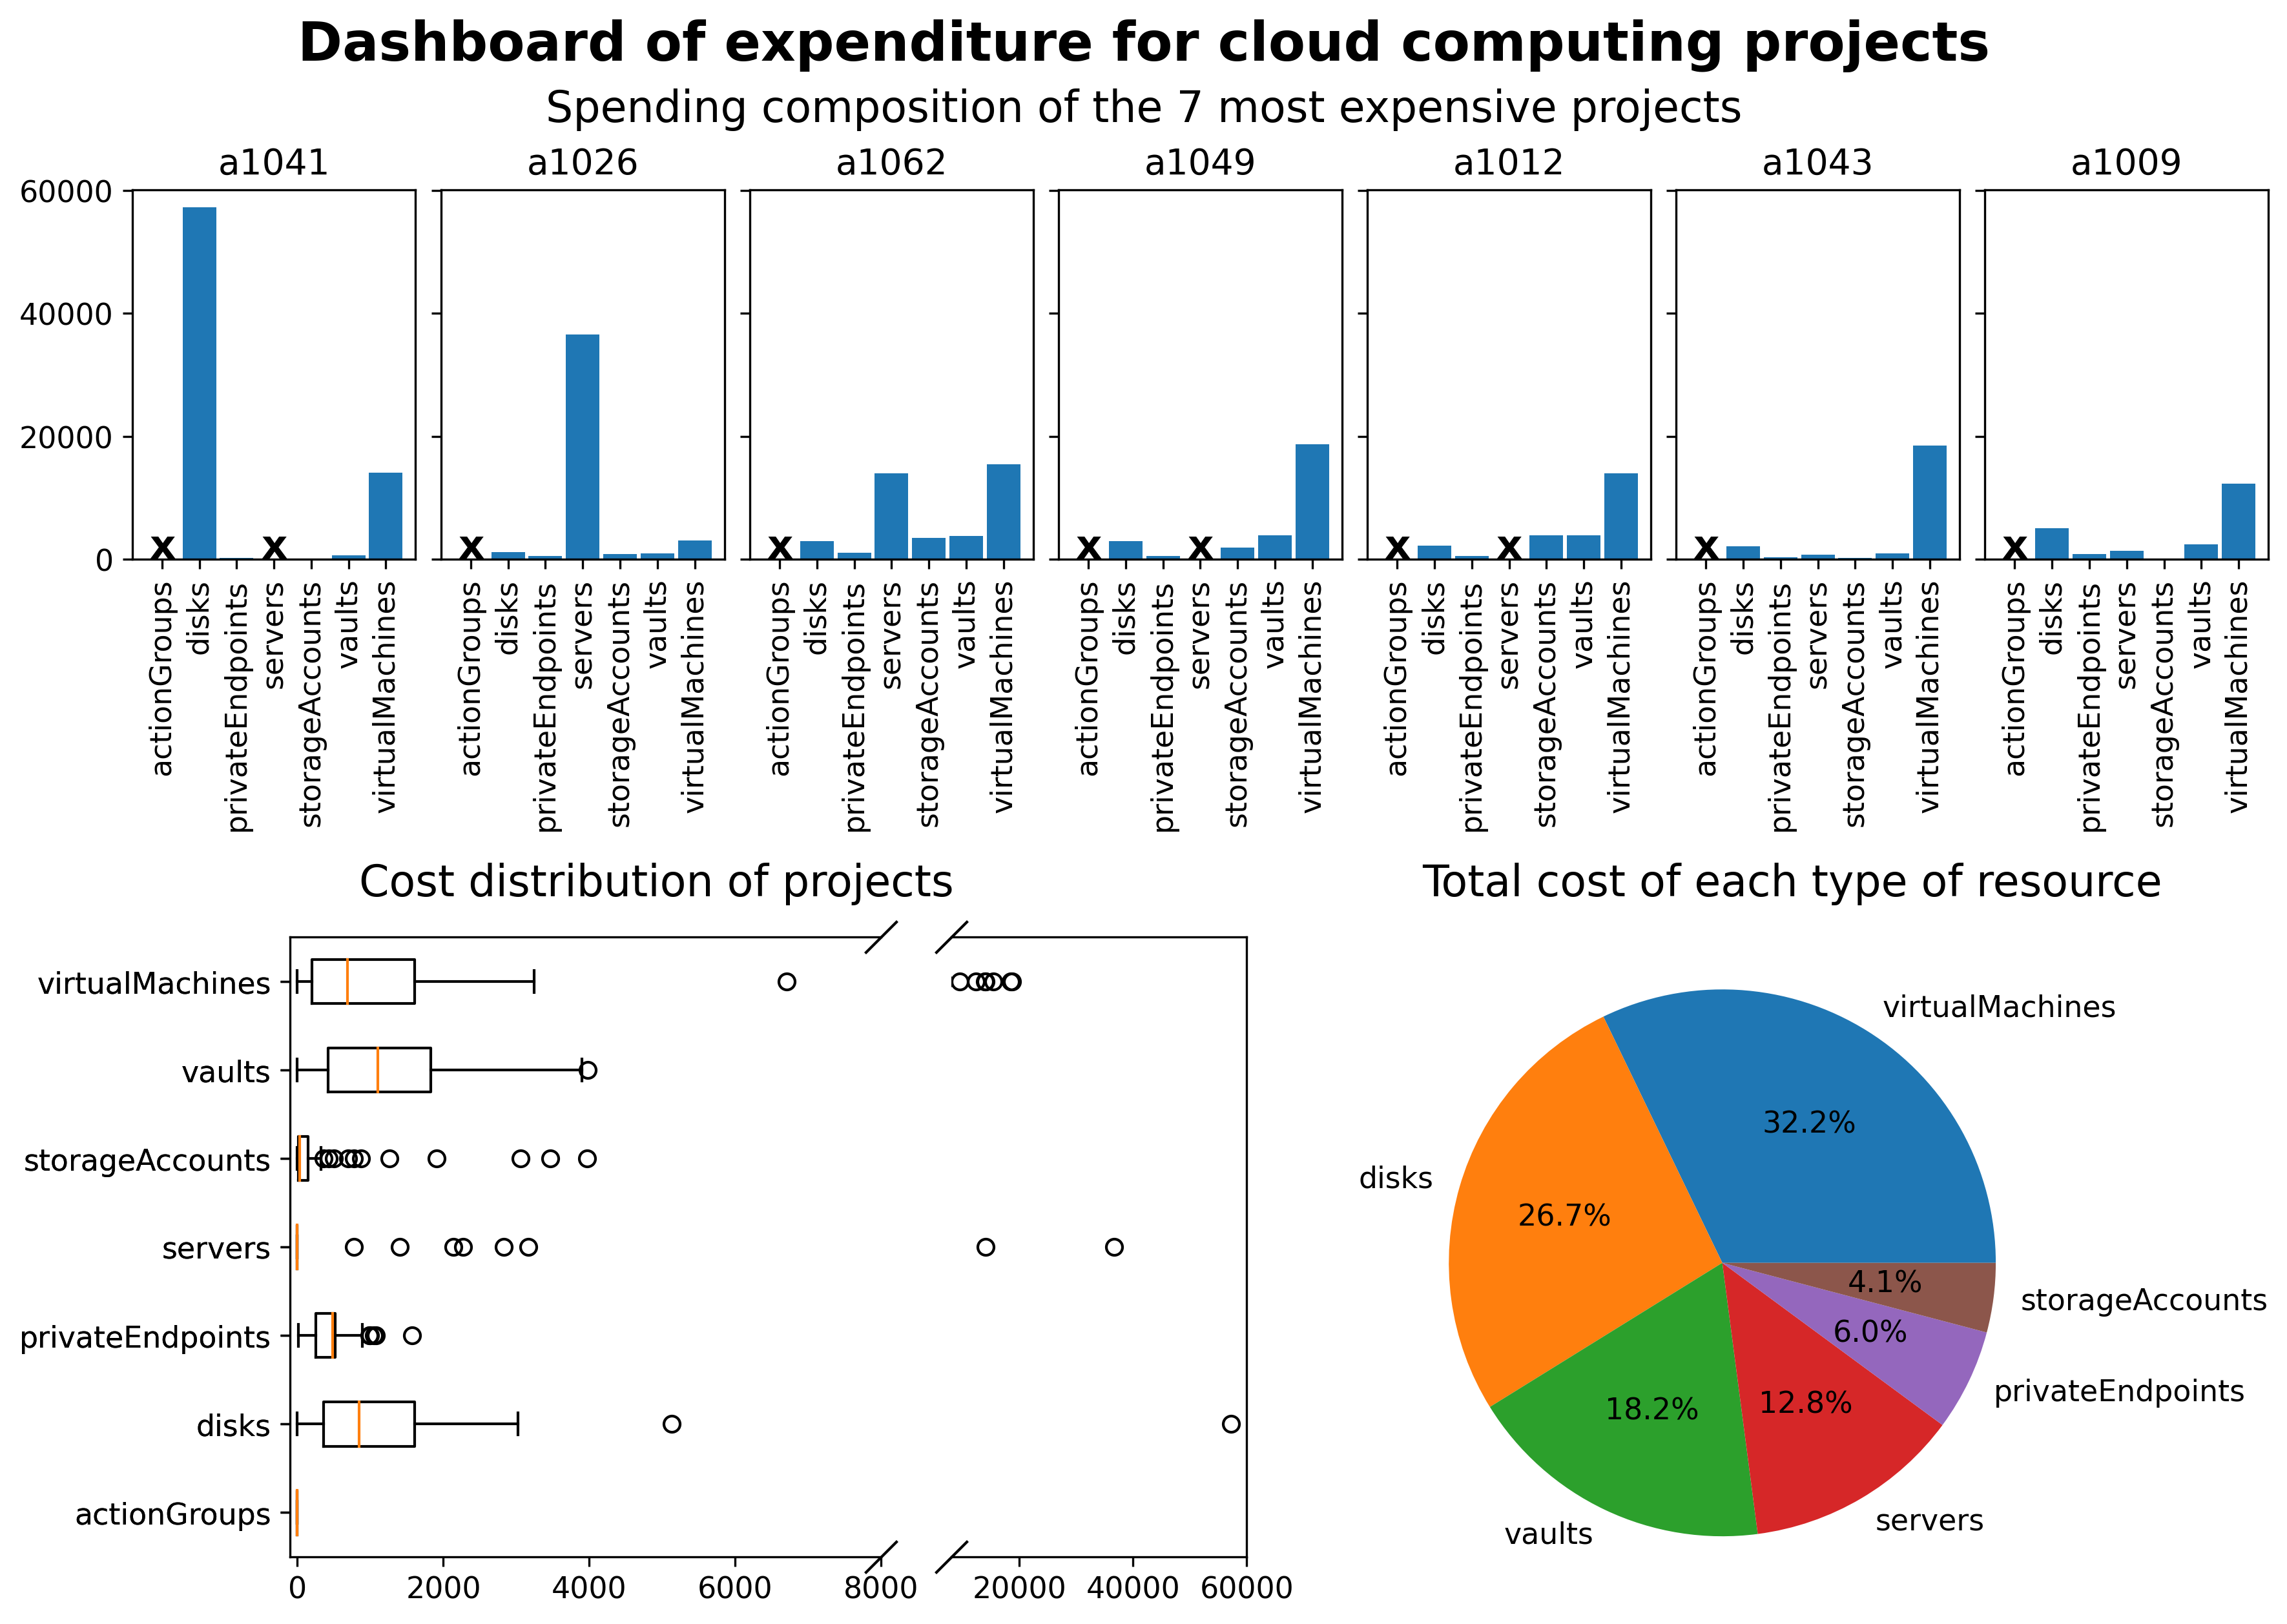

In [6]:
fig = plt.figure(figsize=(11.69, 8.27), dpi=300, constrained_layout=True)
gs = GridSpec(2, 7, figure=fig)
fig.suptitle('Dashboard of expenditure for cloud computing projects', fontsize=20, weight='bold')

# Bar charts
f = fig.add_subfigure(gs[0, :])
f.suptitle('Spending composition of the 7 most expensive projects', fontsize=16)
axs = f.subplots(1, 7, sharey='row')
for ax, (label, data) in zip(axs, prices_per_resource.iloc[:, :7].items()):
    plot_bar(ax, label, data)

# Box plots
f = fig.add_subfigure(gs[1, :4])
gs2 = GridSpec(1, 3, figure=f)
f.suptitle('Cost distribution of projects', fontsize=16)
ax1 = f.add_subplot(gs2[0, :2])
ax2 = f.add_subplot(gs2[0, 2], sharey=ax1)
plot_box(ax1, ax2)

# Pie chart
f = fig.add_subfigure(gs[1, 4:])
f.suptitle("Total cost of each type of resource", fontsize=16)
ax = f.subplots(1, 1)
ax.pie(resource_cost, labels=resource_cost.index, autopct='%1.1f%%')

plt.show()